<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Wed Jun 11 14:12:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   32C    P8              6W /   60W |     639MiB /   4096MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.6.0+cu126


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

* Early stopping: stop training when the tain loss and test loss rach optimal value
* Learning rate scheduling: changing learning rate to optimizer loss values
* Increase data: 
* Better data
* Simpler model 
* Use transfer learning


## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [5]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data_exercise/")
image_path = data_path / "pizza_stake_sushi"


# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory , creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data....")
        f.write(request.content)
        
    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data_exercise\pizza_stake_sushi directory , creating one...
Unzipping pizza, steak, sushi data...


In [6]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data_exercise/pizza_stake_sushi/train'),
 WindowsPath('data_exercise/pizza_stake_sushi/test'))

Random image path: data_exercise\pizza_stake_sushi\train\pizza\2811032.jpg
Image class: pizza
Image height: 512
Image width: 512


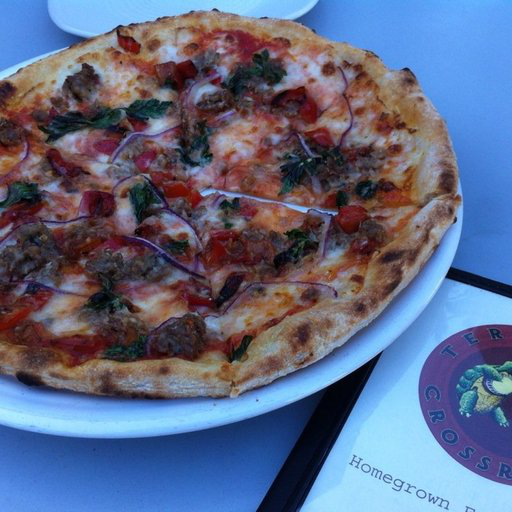

In [63]:
# Visualize an image
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name 
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

<Figure size 1000x700 with 0 Axes>

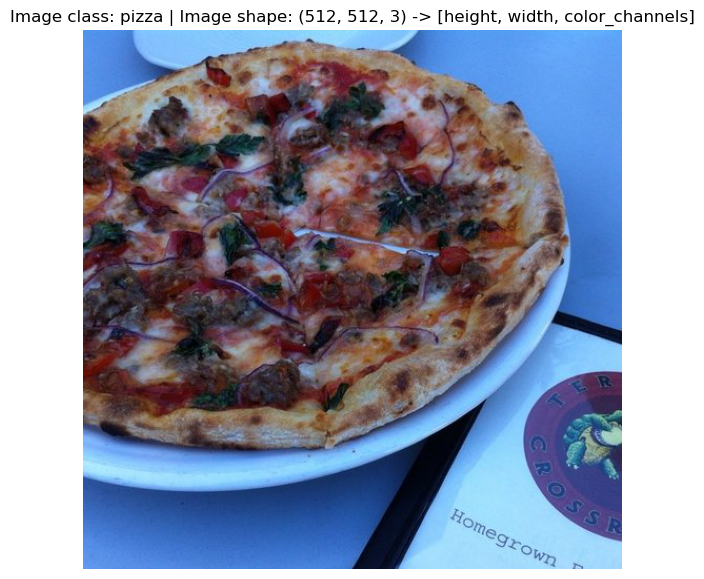

In [66]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.array(img)
plt.figure(figsize=(10, 7))

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [170]:
# 3.1 Transforming data with torchvision.transforms
import torch 
from torch.utils.data import dataloader
from torchvision import transforms

transformation = transforms.Compose([
  # Resize the images to 64x64x3 (64 height, 64 width, 3 color channels)
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() # converts all pixel values from 0-255 to be between 0-1
])

In [171]:
# Write transform for turning images into tensors
transformation(img).shape

torch.Size([3, 64, 64])

In [172]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths: list, transform, n =3, seed=None):
    
    if seed:
        random.seed(seed)
        
    random_image_paths = random.sample(image_paths, k=n)
    
    for img_path in random_image_paths:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

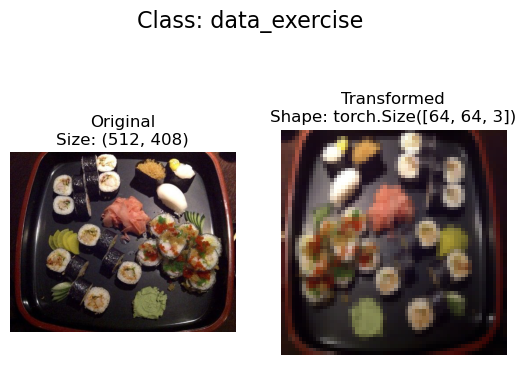

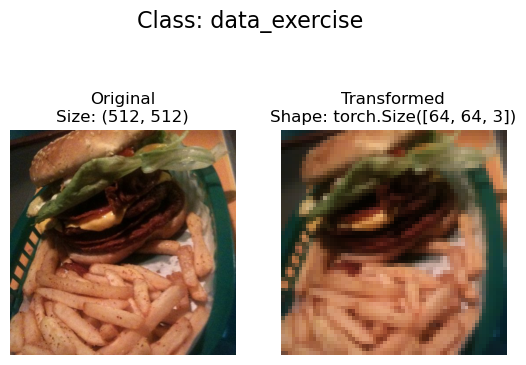

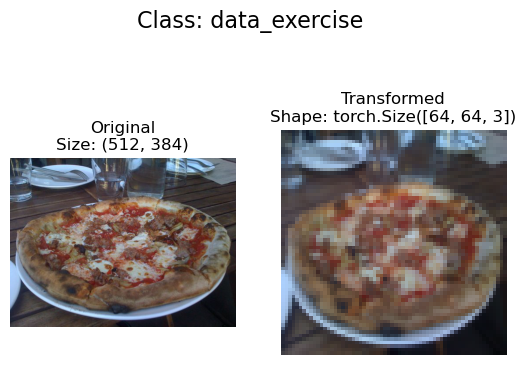

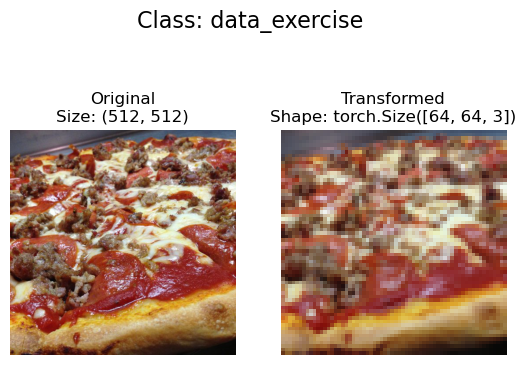

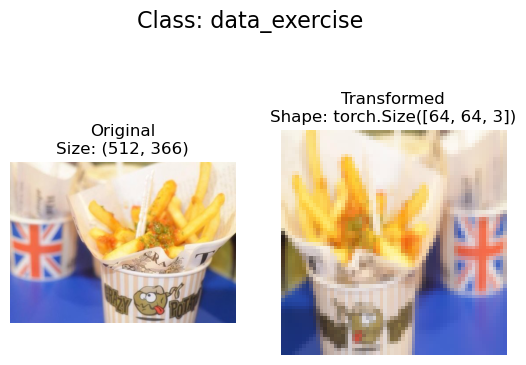

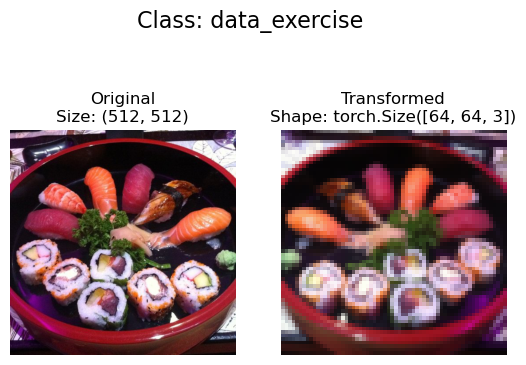

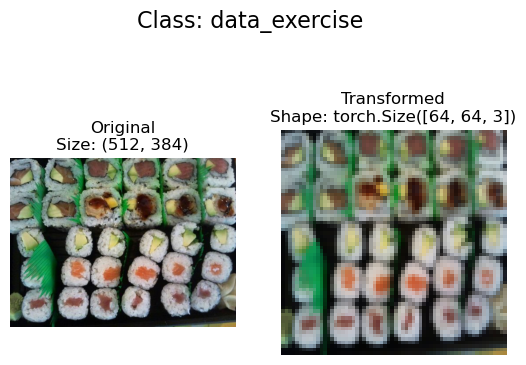

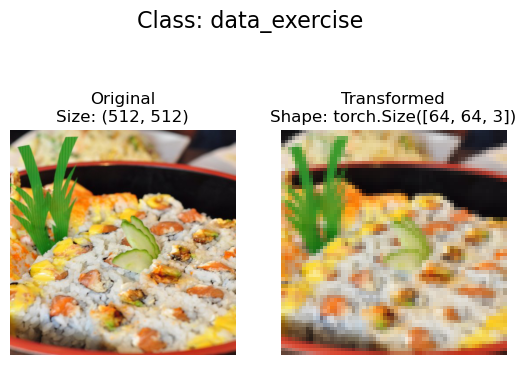

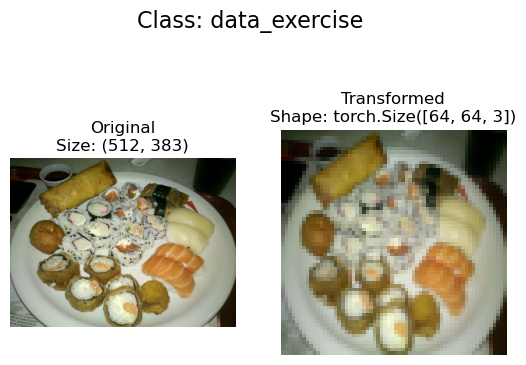

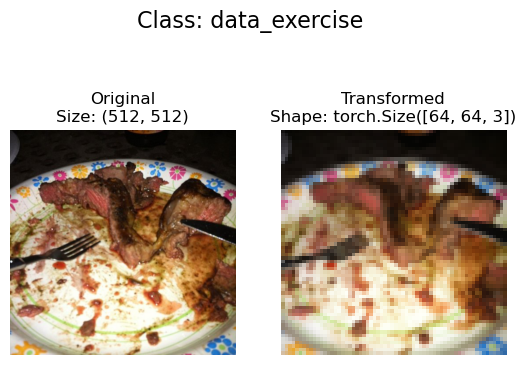

In [173]:
plot_transformed_images(image_path_list, transform=transformation,n=10, seed=42)

### Load image data using `ImageFolder`

In [174]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                                transform=transformation,
                                )

test_data = ImageFolder(root=test_dir,
                                transform=transformation)
print(f"train_data:\n {train_data} - test data:\n {test_data}")

train_data:
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: data_exercise\pizza_stake_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) - test data:
 Dataset ImageFolder
    Number of datapoints: 75
    Root location: data_exercise\pizza_stake_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [175]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [176]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [177]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [178]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=0
train_data_loader = DataLoader(dataset=train_data,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=NUM_WORKERS)

test_data_loader = DataLoader(dataset=test_data,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS)

train_data_loader, test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x2c35441e980>,
 <torch.utils.data.dataloader.DataLoader at 0x2c35441ee60>)

In [179]:
# How many batches of images are in our data loaders?
len(train_data_loader), len(test_data_loader)

(8, 3)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [180]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape))
        
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

In [181]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0 

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [182]:
img_batch , label_batch = next(iter(train_data_loader))
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [183]:
model_0(img_batch.to(device))

tensor([[ 2.0681e-02, -1.8440e-03,  1.0159e-02],
        [ 1.9353e-02,  3.1454e-03,  7.4342e-03],
        [ 1.8362e-02,  1.9810e-03,  8.1708e-03],
        [ 2.1054e-02, -2.6098e-03,  1.0278e-02],
        [ 2.1966e-02,  1.8808e-04,  1.0136e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 1.9515e-02, -1.1002e-03,  1.2317e-02],
        [ 1.8847e-02, -2.3140e-03,  9.4953e-03],
        [ 2.5128e-02, -4.1492e-03,  1.2148e-02],
        [ 2.0252e-02, -4.7293e-04,  1.0908e-02],
        [ 1.9959e-02, -2.9724e-03,  8.2744e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.2771e-02, -2.9104e-03,  9.9718e-03],
        [ 1.9791e-02, -2.7065e-04,  9.8531e-03],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2590e-02, -3.3919e-03,  1.0587e-02],
        [ 2.0159e-02, -2.1909e-03,  9.5485e-03],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 2.1307e-02, -9.6464e-04,  1.0219e-02],
        [ 1.9069e-02, -8.9501e-05,  9.4218e-03],
        [ 1.7441e-02

## 4. Create training and testing functions for `model_0`.

In [208]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y =  X.to(device), y.to(device)    
    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item() # gets the raw Python float value to accumulate it.
    
    # 3. Optimizer zero grad 
    optimizer.zero_grad() # Clears old gradients. Required before loss.backward().

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred) # Compares predictions to labels and computes batch accuracy.
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 

In [212]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y =  X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      
      # Calculate and accumulate accuracy
      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [210]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [213]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_data_loader,
                        test_dataloader=test_data_loader,
                        optimizer=optimizer,
                        epochs=5)

 20%|██        | 1/5 [00:01<00:05,  1.38s/it]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3086 | test_loss: 1.0989 | test_acc: 0.2292


 40%|████      | 2/5 [00:02<00:04,  1.43s/it]

Epoch: 2 | train_loss: 1.1059 | train_acc: 0.2891 | test_loss: 1.0684 | test_acc: 0.5417


 60%|██████    | 3/5 [00:04<00:02,  1.46s/it]

Epoch: 3 | train_loss: 1.1014 | train_acc: 0.3477 | test_loss: 1.0911 | test_acc: 0.3911


 80%|████████  | 4/5 [00:05<00:01,  1.47s/it]

Epoch: 4 | train_loss: 1.0843 | train_acc: 0.4922 | test_loss: 1.0923 | test_acc: 0.3333


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

Epoch: 5 | train_loss: 1.0378 | train_acc: 0.5664 | test_loss: 1.0722 | test_acc: 0.3002


In [ ]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                            lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_data_loader,
                        test_dataloader=test_data_loader,
                        optimizer=optimizer,
                        epochs=20)


 10%|█         | 1/10 [00:01<00:13,  1.52s/it]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3086 | test_loss: 1.0989 | test_acc: 0.2292


 20%|██        | 2/10 [00:02<00:11,  1.42s/it]

Epoch: 2 | train_loss: 1.1059 | train_acc: 0.2891 | test_loss: 1.0684 | test_acc: 0.5417


 30%|███       | 3/10 [00:04<00:09,  1.41s/it]

Epoch: 3 | train_loss: 1.1015 | train_acc: 0.3438 | test_loss: 1.0912 | test_acc: 0.3911


 40%|████      | 4/10 [00:05<00:08,  1.45s/it]

Epoch: 4 | train_loss: 1.0843 | train_acc: 0.4922 | test_loss: 1.0923 | test_acc: 0.3333


 50%|█████     | 5/10 [00:07<00:07,  1.43s/it]

Epoch: 5 | train_loss: 1.0382 | train_acc: 0.5664 | test_loss: 1.0726 | test_acc: 0.3002


 60%|██████    | 6/10 [00:08<00:05,  1.42s/it]

Epoch: 6 | train_loss: 0.9945 | train_acc: 0.6328 | test_loss: 1.0523 | test_acc: 0.3523


 70%|███████   | 7/10 [00:10<00:04,  1.45s/it]

Epoch: 7 | train_loss: 0.8808 | train_acc: 0.5742 | test_loss: 1.2108 | test_acc: 0.2812


 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]

Epoch: 8 | train_loss: 0.8892 | train_acc: 0.6289 | test_loss: 1.0357 | test_acc: 0.3835


 90%|█████████ | 9/10 [00:12<00:01,  1.42s/it]

Epoch: 9 | train_loss: 0.8706 | train_acc: 0.5820 | test_loss: 1.0292 | test_acc: 0.5360


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

Epoch: 10 | train_loss: 1.1333 | train_acc: 0.4883 | test_loss: 0.9515 | test_acc: 0.4839


In [221]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                            lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_data_loader,
                        test_dataloader=test_data_loader,
                        optimizer=optimizer,
                        epochs=50)


  2%|▏         | 1/50 [00:01<01:12,  1.49s/it]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3086 | test_loss: 1.0989 | test_acc: 0.2292


  4%|▍         | 2/50 [00:02<01:11,  1.49s/it]

Epoch: 2 | train_loss: 1.1059 | train_acc: 0.2891 | test_loss: 1.0684 | test_acc: 0.5417


  6%|▌         | 3/50 [00:04<01:12,  1.53s/it]

Epoch: 3 | train_loss: 1.1015 | train_acc: 0.3438 | test_loss: 1.0912 | test_acc: 0.3911


  8%|▊         | 4/50 [00:06<01:08,  1.50s/it]

Epoch: 4 | train_loss: 1.0843 | train_acc: 0.4922 | test_loss: 1.0923 | test_acc: 0.3333


 10%|█         | 5/50 [00:07<01:06,  1.47s/it]

Epoch: 5 | train_loss: 1.0382 | train_acc: 0.5664 | test_loss: 1.0726 | test_acc: 0.3002


 12%|█▏        | 6/50 [00:08<01:05,  1.48s/it]

Epoch: 6 | train_loss: 0.9946 | train_acc: 0.6328 | test_loss: 1.0526 | test_acc: 0.3523


 14%|█▍        | 7/50 [00:10<01:02,  1.45s/it]

Epoch: 7 | train_loss: 0.8817 | train_acc: 0.5742 | test_loss: 1.2080 | test_acc: 0.2812


 16%|█▌        | 8/50 [00:11<01:01,  1.48s/it]

Epoch: 8 | train_loss: 0.8906 | train_acc: 0.6250 | test_loss: 1.0441 | test_acc: 0.3939


 18%|█▊        | 9/50 [00:13<01:00,  1.47s/it]

Epoch: 9 | train_loss: 0.8706 | train_acc: 0.5859 | test_loss: 1.0211 | test_acc: 0.5559


 20%|██        | 10/50 [00:14<00:57,  1.44s/it]

Epoch: 10 | train_loss: 1.1379 | train_acc: 0.4805 | test_loss: 0.9529 | test_acc: 0.4631


 22%|██▏       | 11/50 [00:16<00:56,  1.44s/it]

Epoch: 11 | train_loss: 0.8904 | train_acc: 0.5664 | test_loss: 1.0680 | test_acc: 0.3731


 24%|██▍       | 12/50 [00:17<00:54,  1.44s/it]

Epoch: 12 | train_loss: 0.9204 | train_acc: 0.5742 | test_loss: 1.0433 | test_acc: 0.4242


 26%|██▌       | 13/50 [00:19<00:53,  1.46s/it]

Epoch: 13 | train_loss: 0.9653 | train_acc: 0.5195 | test_loss: 1.0707 | test_acc: 0.4138


 28%|██▊       | 14/50 [00:20<00:51,  1.44s/it]

Epoch: 14 | train_loss: 0.8239 | train_acc: 0.6562 | test_loss: 1.0251 | test_acc: 0.3826


 30%|███       | 15/50 [00:21<00:50,  1.45s/it]

Epoch: 15 | train_loss: 0.8587 | train_acc: 0.6719 | test_loss: 1.0011 | test_acc: 0.4640


 32%|███▏      | 16/50 [00:23<00:49,  1.45s/it]

Epoch: 16 | train_loss: 0.8658 | train_acc: 0.5391 | test_loss: 0.9438 | test_acc: 0.5445


 34%|███▍      | 17/50 [00:24<00:47,  1.44s/it]

Epoch: 17 | train_loss: 0.8541 | train_acc: 0.5156 | test_loss: 0.9475 | test_acc: 0.4934


 36%|███▌      | 18/50 [00:26<00:45,  1.42s/it]

Epoch: 18 | train_loss: 0.7585 | train_acc: 0.6719 | test_loss: 1.0700 | test_acc: 0.3409


 38%|███▊      | 19/50 [00:27<00:43,  1.39s/it]

Epoch: 19 | train_loss: 0.7743 | train_acc: 0.6406 | test_loss: 1.0704 | test_acc: 0.3617


 40%|████      | 20/50 [00:28<00:41,  1.38s/it]

Epoch: 20 | train_loss: 0.7723 | train_acc: 0.6562 | test_loss: 1.0541 | test_acc: 0.3920


 42%|████▏     | 21/50 [00:30<00:39,  1.36s/it]

Epoch: 21 | train_loss: 0.8021 | train_acc: 0.6602 | test_loss: 1.0216 | test_acc: 0.4441


 44%|████▍     | 22/50 [00:31<00:38,  1.39s/it]

Epoch: 22 | train_loss: 0.7909 | train_acc: 0.7031 | test_loss: 1.0170 | test_acc: 0.3920


 46%|████▌     | 23/50 [00:33<00:38,  1.41s/it]

Epoch: 23 | train_loss: 0.8053 | train_acc: 0.6523 | test_loss: 1.0050 | test_acc: 0.4441


 48%|████▊     | 24/50 [00:34<00:37,  1.45s/it]

Epoch: 24 | train_loss: 0.7780 | train_acc: 0.7188 | test_loss: 1.0712 | test_acc: 0.4650


 50%|█████     | 25/50 [00:36<00:36,  1.45s/it]

Epoch: 25 | train_loss: 1.3316 | train_acc: 0.5703 | test_loss: 1.0028 | test_acc: 0.4034


 52%|█████▏    | 26/50 [00:37<00:33,  1.39s/it]

Epoch: 26 | train_loss: 0.7854 | train_acc: 0.6641 | test_loss: 1.0744 | test_acc: 0.3835


 54%|█████▍    | 27/50 [00:38<00:31,  1.38s/it]

Epoch: 27 | train_loss: 0.9440 | train_acc: 0.4922 | test_loss: 0.9829 | test_acc: 0.4242


 56%|█████▌    | 28/50 [00:40<00:31,  1.43s/it]

Epoch: 28 | train_loss: 0.9252 | train_acc: 0.5547 | test_loss: 0.9549 | test_acc: 0.5350


 58%|█████▊    | 29/50 [00:41<00:28,  1.34s/it]

Epoch: 29 | train_loss: 0.8419 | train_acc: 0.6836 | test_loss: 1.0079 | test_acc: 0.4848


 60%|██████    | 30/50 [00:42<00:26,  1.33s/it]

Epoch: 30 | train_loss: 0.8500 | train_acc: 0.7031 | test_loss: 0.9400 | test_acc: 0.5549


 62%|██████▏   | 31/50 [00:43<00:24,  1.29s/it]

Epoch: 31 | train_loss: 0.7948 | train_acc: 0.6055 | test_loss: 0.9763 | test_acc: 0.4233


 64%|██████▍   | 32/50 [00:45<00:24,  1.35s/it]

Epoch: 32 | train_loss: 0.9221 | train_acc: 0.5664 | test_loss: 1.0332 | test_acc: 0.3314


 66%|██████▌   | 33/50 [00:46<00:22,  1.32s/it]

Epoch: 33 | train_loss: 0.7659 | train_acc: 0.6797 | test_loss: 0.9975 | test_acc: 0.4337


 68%|██████▊   | 34/50 [00:48<00:22,  1.38s/it]

Epoch: 34 | train_loss: 0.6720 | train_acc: 0.7305 | test_loss: 0.9359 | test_acc: 0.4839


 70%|███████   | 35/50 [00:49<00:20,  1.34s/it]

Epoch: 35 | train_loss: 0.7090 | train_acc: 0.6992 | test_loss: 0.9529 | test_acc: 0.4943


 72%|███████▏  | 36/50 [00:50<00:19,  1.39s/it]

Epoch: 36 | train_loss: 0.6830 | train_acc: 0.7461 | test_loss: 1.0021 | test_acc: 0.4233


 74%|███████▍  | 37/50 [00:52<00:18,  1.41s/it]

Epoch: 37 | train_loss: 0.7596 | train_acc: 0.6016 | test_loss: 1.0509 | test_acc: 0.4025


 76%|███████▌  | 38/50 [00:53<00:16,  1.36s/it]

Epoch: 38 | train_loss: 0.7658 | train_acc: 0.6797 | test_loss: 1.1017 | test_acc: 0.4233


 78%|███████▊  | 39/50 [00:55<00:15,  1.40s/it]

Epoch: 39 | train_loss: 0.7682 | train_acc: 0.5977 | test_loss: 0.9496 | test_acc: 0.4347


 80%|████████  | 40/50 [00:56<00:13,  1.35s/it]

Epoch: 40 | train_loss: 0.7470 | train_acc: 0.6680 | test_loss: 0.9968 | test_acc: 0.4337


 82%|████████▏ | 41/50 [00:57<00:12,  1.34s/it]

Epoch: 41 | train_loss: 0.6989 | train_acc: 0.7070 | test_loss: 1.2045 | test_acc: 0.3409


 84%|████████▍ | 42/50 [00:58<00:10,  1.29s/it]

Epoch: 42 | train_loss: 0.6702 | train_acc: 0.7070 | test_loss: 1.1207 | test_acc: 0.4223


 86%|████████▌ | 43/50 [01:00<00:09,  1.36s/it]

Epoch: 43 | train_loss: 0.6544 | train_acc: 0.7305 | test_loss: 1.0247 | test_acc: 0.4347


 88%|████████▊ | 44/50 [01:01<00:08,  1.33s/it]

Epoch: 44 | train_loss: 0.6891 | train_acc: 0.7344 | test_loss: 1.0119 | test_acc: 0.4337


 90%|█████████ | 45/50 [01:02<00:06,  1.34s/it]

Epoch: 45 | train_loss: 0.6758 | train_acc: 0.7500 | test_loss: 1.0481 | test_acc: 0.4138


 92%|█████████▏| 46/50 [01:04<00:05,  1.36s/it]

Epoch: 46 | train_loss: 0.7493 | train_acc: 0.7344 | test_loss: 0.9933 | test_acc: 0.4744


 94%|█████████▍| 47/50 [01:05<00:04,  1.34s/it]

Epoch: 47 | train_loss: 0.9168 | train_acc: 0.6289 | test_loss: 1.0502 | test_acc: 0.4233


 96%|█████████▌| 48/50 [01:06<00:02,  1.31s/it]

Epoch: 48 | train_loss: 0.8559 | train_acc: 0.5820 | test_loss: 1.1246 | test_acc: 0.3523


 98%|█████████▊| 49/50 [01:08<00:01,  1.37s/it]

Epoch: 49 | train_loss: 0.8513 | train_acc: 0.5664 | test_loss: 1.0752 | test_acc: 0.4138


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Epoch: 50 | train_loss: 0.6766 | train_acc: 0.7383 | test_loss: 0.9478 | test_acc: 0.5066


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [217]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), 
                            lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_data_loader,
                        test_dataloader=test_data_loader,
                        optimizer=optimizer,
                        epochs=20)


  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

Epoch: 1 | train_loss: 1.1039 | train_acc: 0.2461 | test_loss: 1.1011 | test_acc: 0.1875


 10%|█         | 2/20 [00:02<00:25,  1.43s/it]

Epoch: 2 | train_loss: 1.0973 | train_acc: 0.2891 | test_loss: 1.1074 | test_acc: 0.2188


 15%|█▌        | 3/20 [00:04<00:25,  1.47s/it]

Epoch: 3 | train_loss: 1.0849 | train_acc: 0.4141 | test_loss: 1.1253 | test_acc: 0.1979


 20%|██        | 4/20 [00:05<00:22,  1.40s/it]

Epoch: 4 | train_loss: 1.0944 | train_acc: 0.2930 | test_loss: 1.1267 | test_acc: 0.2604


 25%|██▌       | 5/20 [00:07<00:21,  1.45s/it]

Epoch: 5 | train_loss: 1.0624 | train_acc: 0.4805 | test_loss: 1.1400 | test_acc: 0.2604


 30%|███       | 6/20 [00:08<00:20,  1.43s/it]

Epoch: 6 | train_loss: 1.0413 | train_acc: 0.4258 | test_loss: 1.1239 | test_acc: 0.2708


 35%|███▌      | 7/20 [00:10<00:18,  1.43s/it]

Epoch: 7 | train_loss: 0.9976 | train_acc: 0.5156 | test_loss: 1.1868 | test_acc: 0.2708


 40%|████      | 8/20 [00:11<00:17,  1.45s/it]

Epoch: 8 | train_loss: 1.1048 | train_acc: 0.3945 | test_loss: 1.1160 | test_acc: 0.2500


 45%|████▌     | 9/20 [00:12<00:15,  1.42s/it]

Epoch: 9 | train_loss: 0.9704 | train_acc: 0.4688 | test_loss: 1.0186 | test_acc: 0.3220


 50%|█████     | 10/20 [00:14<00:14,  1.48s/it]

Epoch: 10 | train_loss: 0.9162 | train_acc: 0.5664 | test_loss: 1.0166 | test_acc: 0.3712


 55%|█████▌    | 11/20 [00:15<00:13,  1.45s/it]

Epoch: 11 | train_loss: 0.8532 | train_acc: 0.6016 | test_loss: 1.1143 | test_acc: 0.3428


 60%|██████    | 12/20 [00:17<00:11,  1.40s/it]

Epoch: 12 | train_loss: 0.8315 | train_acc: 0.5859 | test_loss: 1.1570 | test_acc: 0.3419


 65%|██████▌   | 13/20 [00:18<00:10,  1.43s/it]

Epoch: 13 | train_loss: 0.8546 | train_acc: 0.6289 | test_loss: 1.0104 | test_acc: 0.3731


 70%|███████   | 14/20 [00:20<00:08,  1.44s/it]

Epoch: 14 | train_loss: 0.8252 | train_acc: 0.6250 | test_loss: 0.9840 | test_acc: 0.4441


 75%|███████▌  | 15/20 [00:21<00:06,  1.40s/it]

Epoch: 15 | train_loss: 0.7789 | train_acc: 0.6914 | test_loss: 1.0505 | test_acc: 0.3930


 80%|████████  | 16/20 [00:22<00:05,  1.40s/it]

Epoch: 16 | train_loss: 0.8131 | train_acc: 0.6719 | test_loss: 1.0325 | test_acc: 0.5161


 85%|████████▌ | 17/20 [00:24<00:04,  1.39s/it]

Epoch: 17 | train_loss: 0.7693 | train_acc: 0.6523 | test_loss: 0.9742 | test_acc: 0.4953


 90%|█████████ | 18/20 [00:25<00:02,  1.39s/it]

Epoch: 18 | train_loss: 0.7116 | train_acc: 0.7031 | test_loss: 0.9814 | test_acc: 0.4650


 95%|█████████▌| 19/20 [00:26<00:01,  1.39s/it]

Epoch: 19 | train_loss: 0.8307 | train_acc: 0.5781 | test_loss: 1.0072 | test_acc: 0.4848


100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

Epoch: 20 | train_loss: 0.7876 | train_acc: 0.7148 | test_loss: 0.9788 | test_acc: 0.5057


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [218]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [219]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [220]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [222]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(root=train_data_20_percent_path,
                                    transform=simple_transform)
test_data_20_percent= ImageFolder(root=test_data_20_percent_path,
                                    transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(dataset=train_data_20_percent,
                                         batch_size=32,
                                         num_workers=0,
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(dataset=test_data_20_percent,
                                         batch_size=32,
                                         num_workers=0,
                                         shuffle=False)


In [234]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_4 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(),
                            lr=0.001)

model_4_results = train(model_4,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

  5%|▌         | 1/20 [00:02<00:56,  2.97s/it]

Epoch: 1 | train_loss: 1.1012 | train_acc: 0.3354 | test_loss: 1.0955 | test_acc: 0.3943


 10%|█         | 2/20 [00:05<00:51,  2.85s/it]

Epoch: 2 | train_loss: 1.1005 | train_acc: 0.3417 | test_loss: 1.0691 | test_acc: 0.3960


 15%|█▌        | 3/20 [00:08<00:49,  2.94s/it]

Epoch: 3 | train_loss: 1.0325 | train_acc: 0.5687 | test_loss: 0.9801 | test_acc: 0.5273


 20%|██        | 4/20 [00:11<00:47,  2.99s/it]

Epoch: 4 | train_loss: 0.9423 | train_acc: 0.5875 | test_loss: 0.9727 | test_acc: 0.4830


 25%|██▌       | 5/20 [00:14<00:43,  2.92s/it]

Epoch: 5 | train_loss: 0.8964 | train_acc: 0.5771 | test_loss: 0.9321 | test_acc: 0.5597


 30%|███       | 6/20 [00:17<00:41,  2.98s/it]

Epoch: 6 | train_loss: 0.8752 | train_acc: 0.6125 | test_loss: 0.9362 | test_acc: 0.5545


 35%|███▌      | 7/20 [00:20<00:38,  2.93s/it]

Epoch: 7 | train_loss: 0.8625 | train_acc: 0.6312 | test_loss: 0.9423 | test_acc: 0.5938


 40%|████      | 8/20 [00:23<00:34,  2.88s/it]

Epoch: 8 | train_loss: 0.8954 | train_acc: 0.5979 | test_loss: 0.9951 | test_acc: 0.5511


 45%|████▌     | 9/20 [00:26<00:31,  2.88s/it]

Epoch: 9 | train_loss: 0.8759 | train_acc: 0.5896 | test_loss: 0.9524 | test_acc: 0.5795


 50%|█████     | 10/20 [00:29<00:29,  2.96s/it]

Epoch: 10 | train_loss: 0.7673 | train_acc: 0.6771 | test_loss: 0.9939 | test_acc: 0.5386


 55%|█████▌    | 11/20 [00:32<00:25,  2.87s/it]

Epoch: 11 | train_loss: 0.7914 | train_acc: 0.6729 | test_loss: 0.9138 | test_acc: 0.5727


 60%|██████    | 12/20 [00:34<00:22,  2.81s/it]

Epoch: 12 | train_loss: 0.7578 | train_acc: 0.6542 | test_loss: 0.9639 | test_acc: 0.5915


 65%|██████▌   | 13/20 [00:37<00:19,  2.76s/it]

Epoch: 13 | train_loss: 0.7385 | train_acc: 0.6833 | test_loss: 0.9208 | test_acc: 0.5631


 70%|███████   | 14/20 [00:39<00:16,  2.71s/it]

Epoch: 14 | train_loss: 0.7406 | train_acc: 0.6521 | test_loss: 0.9500 | test_acc: 0.5852


 75%|███████▌  | 15/20 [00:42<00:13,  2.69s/it]

Epoch: 15 | train_loss: 0.6643 | train_acc: 0.7208 | test_loss: 0.9423 | test_acc: 0.5943


 80%|████████  | 16/20 [00:45<00:10,  2.74s/it]

Epoch: 16 | train_loss: 0.6499 | train_acc: 0.7063 | test_loss: 1.0032 | test_acc: 0.5813


 85%|████████▌ | 17/20 [00:48<00:08,  2.76s/it]

Epoch: 17 | train_loss: 0.6495 | train_acc: 0.7188 | test_loss: 1.0243 | test_acc: 0.5443


 90%|█████████ | 18/20 [00:51<00:05,  2.76s/it]

Epoch: 18 | train_loss: 0.6465 | train_acc: 0.7229 | test_loss: 0.9390 | test_acc: 0.6034


 95%|█████████▌| 19/20 [00:53<00:02,  2.74s/it]

Epoch: 19 | train_loss: 0.6062 | train_acc: 0.7542 | test_loss: 0.9453 | test_acc: 0.5972


100%|██████████| 20/20 [00:56<00:00,  2.82s/it]

Epoch: 20 | train_loss: 0.5714 | train_acc: 0.7562 | test_loss: 1.0417 | test_acc: 0.5676


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [235]:
# Get a custom image
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [236]:
# Load the image
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

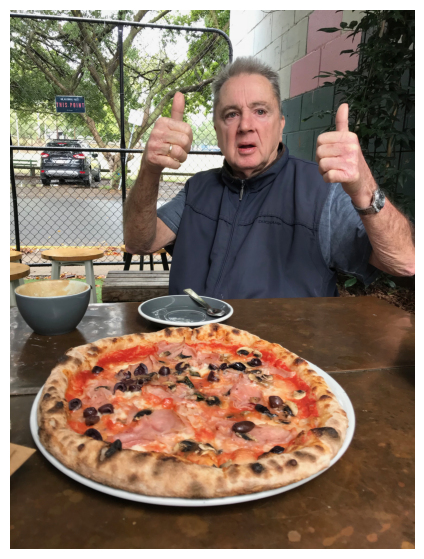

In [237]:
# View the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

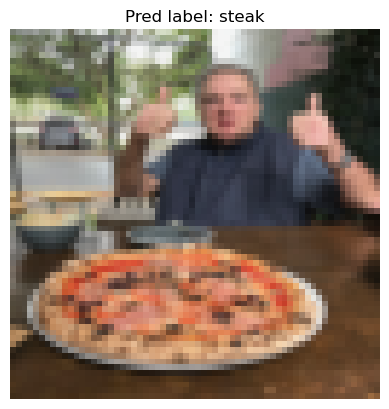

In [238]:
# Make a prediction on the image
model_4.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_4(batch) 

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);